In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# параметры 1d распределений, mu - матожидание, сигма - среднеквадратическое отклонение
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [3]:
# юзаем torch для задания непрерывной функции распределения
d0 = torch.distributions.Normal(torch.tensor([mu0]), torch.tensor([sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))
d1.sample((2,))

tensor([[2.7750],
        [4.7470]])

In [4]:
def sample(d0, d1, n=32):
    # из переданных распределений (функций) набираем экземпляры обучающей выборки, n случайных штук из каждого распределения
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    
    # добавляем правильные ответы. считаем что принадлежность к 
    # d0 это класс 0 
    # d1 это класс 1 
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    
    # в результате надо вернуть два тензора. 
    # первый - со значениями функций
    # второй - "класс" функции которому принадлежит соответствующее значение
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [5]:
sample(d0, d1, 2)

(tensor([[-2.7551],
         [-1.9644],
         [ 3.6594],
         [ 0.2636]]),
 tensor([[0.],
         [0.],
         [1.],
         [1.]]))

In [6]:
# Сделаем нейросетку из одного слоя и одного нейрона (1 вход и 1 выход)
# Applies a linear transformation to the incoming data: y = xA^T + b
# https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
layer = nn.Linear(1, 1)

# посмотрим на параметры и данные:
print(layer.parameters)
for one_parameter in layer.parameters():
    print(one_parameter.data)
    
# теперь как будем оптимизировать ошибку:
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

<bound method Module.parameters of Linear(in_features=1, out_features=1, bias=True)>
tensor([[0.0578]])
tensor([0.2202])


In [7]:
%%time
# теперь будем обучать
log_freq = 500

# обучаемся 10к итераций
for i in range(10000):
    # раз в 500 итераций проверяем качество
    if i%log_freq == 0:
        # этот блок будет выполнен без подсчета градиентов вообще
        with torch.no_grad():
            # тестовой выборки у нас нет, но есть знания о распределениях
            # поэтому просто насемплируем новых данных, которых сеть не видела
            # и на которых не обучалась - будет эквивалент тестовой выборки
            x, y = sample(d0, d1, 100000)
            
            # тут два действия в одном - пропускаем через сумматор (layer)
            # и выходы сумматора пропускаем через функцию активации
            out = torch.sigmoid(layer(x))
            
            # в качестве метрики ошибки считаем бинарную кросс-энтропию между ответами сети 
            # и реальными значениями классов
            loss = F.binary_cross_entropy(out, y)
        print(f"Ошибка после {i} итераций: {round(loss.item(),4)}")
    
    # torch накапливает градиенты, поэтому принудительно перед их новым подсчетом обнуляем накопленные значений
    layer_opt.zero_grad()
    
    # нужно относительно чего-то считать ошибку
    # вот по этим ответам и посчитаем:
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    
    # относительно полученного лосса и будем делать
    loss = F.binary_cross_entropy(out, y)
    # бэкпроп - считаем градиенты
    loss.backward()
    # и не забыть апдейтнуть веса по посчитанным градиентам
    layer_opt.step()

Ошибка после 0 итераций: 0.6322
Ошибка после 500 итераций: 0.3513
Ошибка после 1000 итераций: 0.2695
Ошибка после 1500 итераций: 0.2295
Ошибка после 2000 итераций: 0.2069
Ошибка после 2500 итераций: 0.1915
Ошибка после 3000 итераций: 0.1809
Ошибка после 3500 итераций: 0.1728
Ошибка после 4000 итераций: 0.1665
Ошибка после 4500 итераций: 0.1617
Ошибка после 5000 итераций: 0.1577
Ошибка после 5500 итераций: 0.1564
Ошибка после 6000 итераций: 0.1522
Ошибка после 6500 итераций: 0.1493
Ошибка после 7000 итераций: 0.1477
Ошибка после 7500 итераций: 0.1468
Ошибка после 8000 итераций: 0.1446
Ошибка после 8500 итераций: 0.1433
Ошибка после 9000 итераций: 0.1427
Ошибка после 9500 итераций: 0.1427
CPU times: user 21.7 s, sys: 224 ms, total: 21.9 s
Wall time: 5.58 s


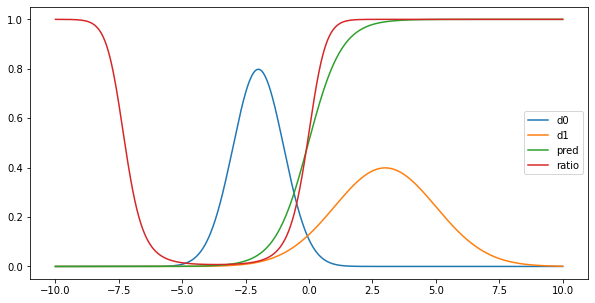

In [8]:
# это для графиков 
x_scale = np.linspace(-10, 10, 5000)
d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)
x_tensor = torch.tensor(x_scale.reshape(-1, 1), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
ratio = d1_pdf / (d1_pdf + d0_pdf)

plt.figure(figsize=(10,5))
plt.plot(x_scale, d0_pdf*2, label='d0') # умножение на 2 для красоты графиков, на распределения не влияет
plt.plot(x_scale, d1_pdf*2, label='d1')
plt.plot(x_scale, dist.flatten(), label='pred')
plt.plot(x_scale, ratio, label='ratio')
plt.legend();

In [9]:
x_tensor

tensor([[-10.0000],
        [ -9.9960],
        [ -9.9920],
        ...,
        [  9.9920],
        [  9.9960],
        [ 10.0000]])

# - - - - - 

### Теперь поменяем исходные данные, чтобы были двумерными

In [10]:
# задаем два распределения, каждое - двумерное
d2_0 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([1., 1.]), torch.tensor([[1, 0.], [0., 1]]))
d2_1 = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([-1., -1.]), torch.tensor([[1, 0.], [0., 1]]))
d2_0.sample((2,))

tensor([[ 0.2312,  2.8757],
        [ 2.8604, -0.1283]])

In [11]:
# сделаем функцию для семплирования двумерных распределений
def sample_2d(d2_0, d2_1, n=32*32):
    # из переданных распределений (функций) набираем экземпляры обучающей выборки, n случайных штук из каждого распределения
    x0 = d2_0.sample((n,))
    x1 = d2_1.sample((n,))
    
    # добавляем правильные ответы. считаем что принадлежность к 
    # d2_0 это класс 0 
    # d2_1 это класс 1 
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    
    # в результате надо вернуть два тензора. 
    # первый - со значениями функций
    # второй - "класс" функции которому принадлежит соответствующее значение
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [12]:
# посмотрим что получается при вызове функции:
sample_2d(d2_0, d2_1, 2)[0].shape

torch.Size([4, 2])

In [13]:
# Сделаем нейросетку из одного слоя и одного нейрона (2 входа и 1 выход)
layer = nn.Linear(2, 1)

# посмотрим на параметры и данные:
print(layer.parameters)
for one_parameter in layer.parameters():
    print(one_parameter.data)
    
# теперь как будем оптимизировать ошибку:
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

<bound method Module.parameters of Linear(in_features=2, out_features=1, bias=True)>
tensor([[0.5115, 0.2608]])
tensor([-0.2844])


In [14]:
%%time
# теперь будем обучать
log_freq = 500
iterations = 10000
# обучаемся 10к итераций
for i in range(iterations):
    # раз в 1000 итераций проверяем качество
    if i%log_freq == 0:
        # этот блок будет выполнен без подсчета градиентов вообще
        with torch.no_grad():
            # тестовой выборки у нас нет, но есть знания о распределениях
            # поэтому просто насемплируем новых данных, которых сеть не видела
            # и на которых не обучалась - будет эквивалент тестовой выборки
            x, y = sample_2d(d2_0, d2_1, 10000)
            
            # тут два действия в одном - пропускаем через сумматор (layer)
            # и выходы сумматора пропускаем через функцию активации
            out = torch.sigmoid(layer(x))
            
            # в качестве метрики ошибки считаем бинарную кросс-энтропию между ответами сети 
            # и реальными значениями классов
            loss = F.binary_cross_entropy(out, y)
        print(f"Ошибка после {i} / {iterations} итераций: {round(loss.item(), 4)}")
    
    # torch накапливает градиенты, поэтому принудительно перед их новым подсчетом обнуляем накопленные значений
    layer_opt.zero_grad()
    
    # нужно относительно чего-то считать ошибку
    # вот по этим ответам и посчитаем:
    x, y = sample_2d(d2_0, d2_1, 1024)
    out = torch.sigmoid(layer(x))
    
    # относительно полученного лосса и будем делать
    loss = F.binary_cross_entropy(out, y)
    # бэкпроп - считаем градиенты
    loss.backward()
    # и не забыть апдейтнуть веса по посчитанным градиентам
    layer_opt.step()

Ошибка после 0 / 10000 итераций: 1.1941
Ошибка после 500 / 10000 итераций: 0.7695
Ошибка после 1000 / 10000 итераций: 0.5567
Ошибка после 1500 / 10000 итераций: 0.4447
Ошибка после 2000 / 10000 итераций: 0.3872
Ошибка после 2500 / 10000 итераций: 0.3464
Ошибка после 3000 / 10000 итераций: 0.3205
Ошибка после 3500 / 10000 итераций: 0.3003
Ошибка после 4000 / 10000 итераций: 0.2831
Ошибка после 4500 / 10000 итераций: 0.2728
Ошибка после 5000 / 10000 итераций: 0.2642
Ошибка после 5500 / 10000 итераций: 0.2526
Ошибка после 6000 / 10000 итераций: 0.2519
Ошибка после 6500 / 10000 итераций: 0.2454
Ошибка после 7000 / 10000 итераций: 0.2421
Ошибка после 7500 / 10000 итераций: 0.236
Ошибка после 8000 / 10000 итераций: 0.2259
Ошибка после 8500 / 10000 итераций: 0.2265
Ошибка после 9000 / 10000 итераций: 0.2269
Ошибка после 9500 / 10000 итераций: 0.22
CPU times: user 27.9 s, sys: 324 ms, total: 28.2 s
Wall time: 7.12 s


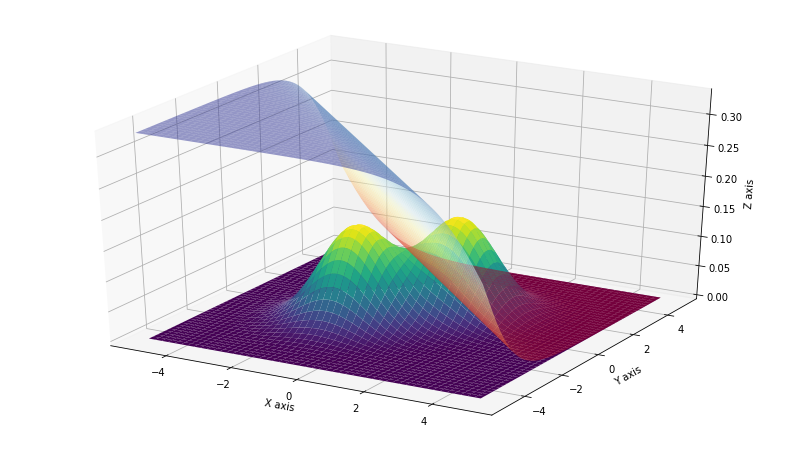

In [15]:
from scipy.stats import multivariate_normal

# Create grid and multivariate normal
x = np.linspace(-5,5,500)
y = np.linspace(-5,5,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

# не забыли подогнать вход модели под нужный формат
model_input = torch.tensor(pos, dtype=torch.float)
d2_0_points = multivariate_normal([1., 1.], [[1.0, 0.], [0., 1]])
d2_1_points = multivariate_normal([-1., -1.], [[1.0, 0.], [0., 1]])
with torch.no_grad():
    model_answers = torch.sigmoid(layer(model_input)).numpy()
model_answers = model_answers[:,:,0]

# Make a 3D plot
fig = plt.figure(figsize=(14,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, d2_0_points.pdf(pos) + d2_1_points.pdf(pos),cmap='viridis',linewidth=0, alpha=1)
ax.plot_surface(X, Y, model_answers/3,cmap='RdYlBu',linewidth=0, alpha=0.5)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()